In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input director
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# **Importing Basic Dependencies**

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import string
import re
import math
import warnings

# **Loading Datasets**

In [3]:
df=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
movies=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
test=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

# **EDA and Preprocessing**

**1. On Datasets**

Null value analysis of movies and train df data is given below.Columns with more than **50%** null values will be dropped

In [4]:
(movies.isnull().sum()/len(movies))*100

movieid                  0.000000
title                    0.000000
audienceScore           48.869871
rating                  90.233704
ratingContents          90.233704
releaseDateTheaters     78.519175
releaseDateStreaming    44.561560
runtimeMinutes           9.651817
genre                    7.736392
originalLanguage         9.673456
director                 0.000000
boxOffice               89.708777
distributor             83.941560
soundType               88.889277
dtype: float64

In [5]:
(df.isnull().sum()/len(df))*100

movieid               0.000000
reviewerName          0.000000
isFrequentReviewer    0.000000
reviewText            3.961096
sentiment             0.000000
dtype: float64

In [6]:
movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [7]:
df.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [8]:
movies.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


**Pie chart below depicts our sentiment distribution 1 is for positive and 0 for negative,No resampling was done as minority class is present in sufficient numbers and also SMOTE reduced acuracy for us.**

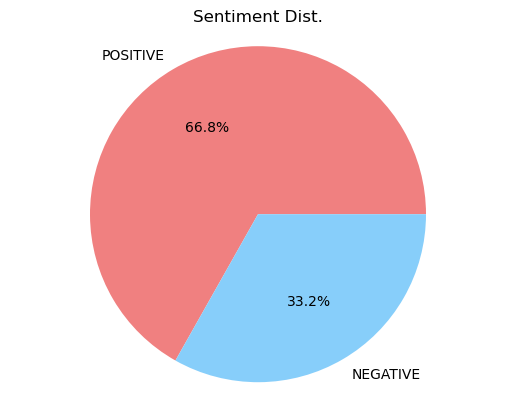

In [9]:
colors = ['lightcoral', 'lightskyblue']

plt.pie(df['sentiment'].value_counts().values, labels=df['sentiment'].value_counts().index, colors=colors, autopct='%1.1f%%')
plt.axis('equal') 

plt.title('Sentiment Dist.')


plt.show()

In [10]:
movies=movies.drop(columns=['rating','ratingContents',
       'releaseDateTheaters','boxOffice',
        'distributor','soundType'])

We will impute other features latr on but **reviewText** column will be imputed now with empty string **''**.

In [11]:
df['reviewText']=df['reviewText'].fillna('')

**2. On Features**

Many features like audienceScore etc. were found to have multiple values for a single unique key during our analysis.Code showing the same is given below:-

In [12]:
print(f'No of Unique movie in movies dataset are: {movies["movieid"].nunique()}')

No of Unique movie in movies dataset are: 126404


In [13]:
aggVals=movies.groupby('movieid').agg({
    'audienceScore':'count',
    'runtimeMinutes':'count',
    'releaseDateStreaming':'count',
    'originalLanguage':'count'
}).reset_index()

aggVals.head()

,movieid,audienceScore,runtimeMinutes,releaseDateStreaming,originalLanguage
0,adventure_anakin_skywalker,1,1,1,1
1,adventure_anakin_skywalker_chronicles_whisper,0,1,1,1
2,adventure_astonish,1,1,1,1
3,adventure_astonish_wondrous_beneath,1,1,1,1
4,adventure_aurora_epic,0,1,1,1


In [14]:
aggVals['audienceScore'].value_counts()

1     61173
0     60217
2      3734
3       840
4       260
5       100
6        41
7        20
8        11
9         7
10        1
Name: audienceScore, dtype: int64

In [15]:
aggVals['releaseDateStreaming'].value_counts()

1     66261
0     54708
2      4019
3       918
4       314
5        95
6        50
7        22
8         9
9         4
12        2
40        1
10        1
Name: releaseDateStreaming, dtype: int64

**Therefore aggregation function for these columns is needed.**

In [16]:
#Aggregating Genre
def agg_genre(data):
  lis=set()
  for index,value in data.items():
    if isinstance(value, float) and math.isnan(value):
      continue

    temp=value.split(',')
    for j in temp:
      lis.add(j.strip().lower())

  lis=set(' '.join(lis).split(' '))

  if len(lis)==0:
    return ''
  else:
    return ' '.join(lis)

#Aggregating runtime
def agg_runtime(data):
  lis=set()
  for index,value in data.items():
    if isinstance(value, float) and math.isnan(value):
      continue

    lis.add(value)

  lis=list(lis)

  if len(lis)==0:
    return np.nan
  else:
    return round(np.quantile(lis,0.5),0)


#Aggregating audience Score
def agg_score(data):
  lis=set()
  for index,value in data.items():
    if isinstance(value, float) and math.isnan(value):
      continue

    lis.add(value)

  lis=list(lis)

  if len(lis)==0:
    return np.nan
  else:
    return round(np.quantile(lis,0.5),0)

#Aggregating language
def agg_lang(data):
  lis=set()
  for index,value in data.items():
    if isinstance(value, float) and math.isnan(value):
      continue

    temp=value.split()
    for j in temp:
      lis.add(j.strip().lower())

  lis=set(' '.join(lis).split(' '))

  if len(lis)==0:
    return np.nan
  else:
    return ' '.join(lis)


#Aggregate Date
def agg_date(data):
 lis=set()
 for index,value in data.items():
    if isinstance(value, float) and math.isnan(value):
        continue
            
    lis.add(value)
    
 lis=list(lis)
 if len(lis)==0:
    return np.nan
 else:
    return lis


#Aggregating Director

def agg_director(data):
  lis=set()
  for index,value in data.items():
    if isinstance(value, float) and math.isnan(value):
      continue

    lis.add(''.join(value.split(' ')))


  lis=list(lis)



  if len(lis)==0:
    return np.nan
  else:
    return ' '.join(lis)


Some preprocessing was needed to bring uniformity among genre:-

In [17]:

codes={
    'Mystery & thriller':'Mystery-Thriller',
    'Faith & spirituality':'Faith',
    'Sports & fitness':'Sports',
    'Health & wellness':'Health',
    'Special interest':'Specials',
    'Gay & lesbian':'LGBTQ+',
    'Kids & family':'Kids',
    'Lgbtq+':'LGBTQ+',
    'Stand-up':'Comedy',
    'Music':'Musical'
}
genre=[]
for index,value in movies['genre'].items():
    if isinstance(value, float) and math.isnan(value):
        continue
    
    temp=value.split(',')
    
    for j in range(len(temp)):
        val=temp[j].strip()
        if val in codes:
            temp[j]=codes[val]
            genre.append(codes[val])
        else:
            temp[j]=val
            genre.append(val)
        
    movies.loc[index,'genre']=' '.join(temp)

set(genre)

{'Action',
 'Adventure',
 'Animation',
 'Anime',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Entertainment',
 'Faith',
 'Fantasy',
 'Foreign',
 'Health',
 'History',
 'Holiday',
 'Horror',
 'Kids',
 'LGBTQ+',
 'Musical',
 'Mystery-Thriller',
 'Nature',
 'News',
 'Other',
 'Reality',
 'Romance',
 'Sci-fi',
 'Short',
 'Specials',
 'Sports',
 'Variety',
 'War',
 'Western'}

In [18]:
movies = movies.groupby('movieid').agg({
                               'title': 'first',
                               'audienceScore':agg_score,
                                'releaseDateStreaming':agg_date,
                                'runtimeMinutes':agg_runtime,
                                'originalLanguage':agg_lang,
                                'genre':agg_genre,
                               'director':agg_director
                               }).reset_index()

**EDA for our reviewText column**

Below are some of the functions to be used to clean text data.It involves:-
1. **removal of stop words**
2. **removing puntuations**
3. **removing square brackets**:its one of the specific difficulties in data where review contains [] mentioning that full review is available somewhere else or in different language. 

In [19]:
PUNCT_TO_REMOVE = string.punctuation


#Some negative words that were affecting our accuracy ahead were omitted from stop words.

#Final list compiled is as follows.

stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "shes", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "youve", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "dont", 
             'very', 'should', 'any', 'y', 'isnt', 'who',  'a', 'they', 'to', 'too', "shouldve", 'has', 'before',
             'into', 'yours', "its", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "thatll", "youd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "youll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all',
            'youre','ive','im','whos']


def remove_punctuation(text):
    
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))



def remove_square_brackets(text):
    
    text_without_brackets = re.sub(r'\[.*?\]', '', text)

    return text_without_brackets



def remove_stopwords(content):
    clean_data = []
    for i in content.split():
        if i.strip().lower() not in stop_words and i.strip().isalpha():
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)


def data_cleaning(content):
    content = remove_square_brackets(content)
    content=remove_punctuation(content)
    content = remove_stopwords(content)
    

    return content

In [20]:
df['cleanedText']=df['reviewText'].apply(data_cleaning)

In [21]:
df.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,cleanedText
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,henry first movie since coraline fifth stopmot...
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,cast reads like vogue oscar party guest list v...
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,creed ii not give us anything but another slig...
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,know thinking but no limitless bradley cooper ...
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,director fernando meirelles tells story urgenc...


**Joining df and movies for further EDA and modeling**

In [22]:
#We are also imputing,encoding for few columns along with merging in this function.
def merge_movies_train(meta,main):
    train = pd.merge(meta,main, on='movieid', how='inner', indicator=True)
    main = train[train['_merge'] == 'both'].drop('_merge', axis=1)
    main['sentiment']=main['sentiment'].replace({'POSITIVE':1,'NEGATIVE':0})
    main['isFrequentReviewer']=main['isFrequentReviewer'].replace({True: 1, False: 0})
    main['reviewText']=main['reviewText'].fillna('')
    
    score_fill=round(main['audienceScore'].mean(),0)
    runtime_fill=round(main['runtimeMinutes'].mean(),0)
    main['audienceScore']=main['audienceScore'].fillna(score_fill)
    main['runtimeMinutes']=main['runtimeMinutes'].fillna(score_fill)
    return main

In [23]:
df=merge_movies_train(movies,df)

In [24]:
df.head()

,movieid,title,audienceScore,releaseDateStreaming,runtimeMinutes,originalLanguage,genre,director,reviewerName,isFrequentReviewer,reviewText,sentiment,cleanedText
0,adventure_captain_america_harry_potter,Adventure Captain America Harry Potter,70.0,[2017-11-07],111.0,(canada) english french,biography romance drama,MichelleRainey DessieGilchrist,Stephanie Arnold,0,"Shine intermittently, especially for its cast ...",1,shine intermittently especially cast especiall...
1,adventure_captain_america_harry_potter,Adventure Captain America Harry Potter,70.0,[2017-11-07],111.0,(canada) english french,biography romance drama,MichelleRainey DessieGilchrist,Suzanne Davidson,1,As in Destin Daniel Cretton's previous feature...,0,destin daniel crettons previous feature short ...
2,adventure_captain_america_harry_potter,Adventure Captain America Harry Potter,70.0,[2017-11-07],111.0,(canada) english french,biography romance drama,MichelleRainey DessieGilchrist,David Allison,1,It's the rare star-driven crowd pleaser smart ...,1,rare stardriven crowd pleaser smart enough pre...
3,adventure_captain_america_harry_potter,Adventure Captain America Harry Potter,70.0,[2017-11-07],111.0,(canada) english french,biography romance drama,MichelleRainey DessieGilchrist,Kenneth Nichols,0,"Slickly sanitized, Destin Daniel Cretton's scr...",0,slickly sanitized destin daniel crettons scree...
4,adventure_captain_america_harry_potter,Adventure Captain America Harry Potter,70.0,[2017-11-07],111.0,(canada) english french,biography romance drama,MichelleRainey DessieGilchrist,Andrew Kramer,0,Maybe she's weighed down by the big hair but [...,0,maybe weighed down big hair but larson left le...


In [25]:
#Seeing calculation for various numverical and umero categorical columns

cols=['audienceScore','runtimeMinutes','isFrequentReviewer']
for j in cols:
    crf=df[j].corr(df['sentiment'])
    print(f"Correlation for {j} with sentiment is {crf}")

Correlation for audienceScore with sentiment is 0.32330197829431323
Correlation for runtimeMinutes with sentiment is 0.04929838669467201
Correlation for isFrequentReviewer with sentiment is -0.05080646901663163


**Adding some custom features related to reviews**

1. Normal word count: No. of words in review without removing stop words.
2. Cleaned word count:No of words in cleaned review text.
3. Mean word length: Mean length of words in cleaned text

In [26]:
#Normal word count
def word_count(content):
    content=remove_square_brackets(content)
    content=remove_punctuation(content)
    
    return len(content.split())

#Number of words in cleaned review
def cleaned_word_count(content):
    return len(content.split())

#Mean word length
def mean_word_length(content):
    lis=[len(word) for word in content.split()]
    if len(lis)==0:
        return 0
    else:
        
        return sum(lis)/len(lis)
    

In [27]:
df['word_count']=df['reviewText'].apply(word_count)
df['cw_count']=df['cleanedText'].apply(cleaned_word_count)
df['mw_len']=df['cleanedText'].apply(mean_word_length)

In [28]:
cols=['word_count','cw_count','mw_len']
for j in cols:
    crf=df[j].corr(df['sentiment'])
    print(f"Correlation for {j} with sentiment is {crf}")


Correlation for word_count with sentiment is 0.03538098241057885
Correlation for cw_count with sentiment is 0.03658466038709025
Correlation for mw_len with sentiment is 0.049386627754427724


All of them doesnt seem to add any meaningful info to our analysis

**Calculating polarity based on our corpus**

As use of external libraries like nltk or textblob was nto allowed,we wrote a simplified version of polarity calculation based on our data


In [29]:
#Finding number of times a word occur in positive review and negative reviews
words=dict()
for index,value in df.iterrows():
    text=value['cleanedText'].split()
    for j in text:
        if j in words:
            if value['sentiment']==1:
                words[j][1]+=1
            else:
                words[j][0]+=1
        else:
            words[j]={1:0,0:0}
            if value['sentiment']==1:
                words[j][1]+=1
            else:
                words[j][0]+=1
            


In [30]:
df['polarity']=np.nan

for index,value in df.iterrows():
    pos=0
    neg=0
    text=value['cleanedText'].split()
    for j in text:
        neg+=words[j][0]
        pos+=words[j][1]
    #This formula gives us a number in between -1 and +1 with number close to -1 indicating 
    # highly negative review and +1 highly positive
    polarity_score = round((pos - neg) / max(1, pos + neg),2)
    if polarity_score==0:
        continue
    else:
        df.loc[index,'polarity']=polarity_score
        

df['polarity']=df['polarity'].fillna(round(df['polarity'].mean(),2))

In [31]:
df['polarity'].corr(df['sentiment'])

0.367532939121942

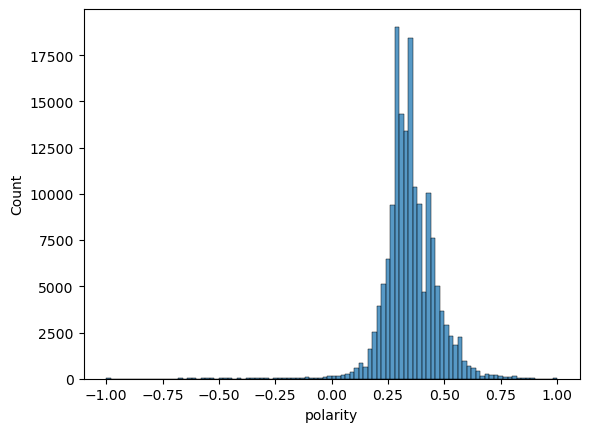

In [32]:
'''Polarity in end lead to 1% increase in accuracy on test data so we decided to keep 
it in the model'''
sns.histplot(df['polarity'],bins=100)
plt.show()

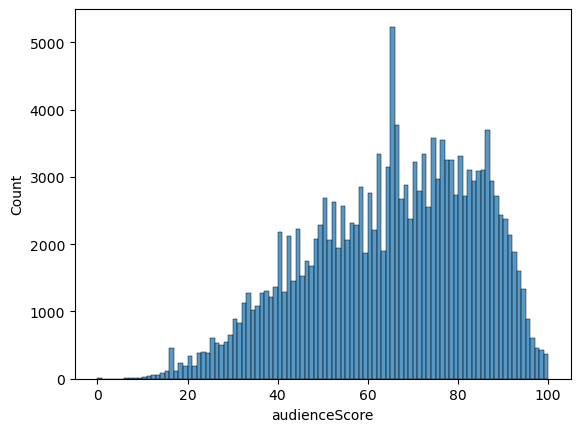

In [33]:
sns.histplot(df['audienceScore'],bins=100)
plt.show()

**Ngram Analysis**

In this section we do deep text analysis. Here we will be using ngrams to analyse the text, based on it's sentiment

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np

def plotNgrams(documents):
    # Create a CountVectorizer instance for unigrams, bigrams, and trigrams
    vectorizer_unigrams = CountVectorizer(ngram_range=(1, 1),max_features=10)
    vectorizer_bigrams = CountVectorizer(ngram_range=(2, 2),max_features=10)
    vectorizer_trigrams = CountVectorizer(ngram_range=(3, 3),max_features=10)

    # Transform the documents into document-term matrices
    X_unigrams = vectorizer_unigrams.fit_transform(documents)
    X_bigrams = vectorizer_bigrams.fit_transform(documents)
    X_trigrams = vectorizer_trigrams.fit_transform(documents)

    # Get the feature names (words) for each n-gram
    words_unigrams = vectorizer_unigrams.get_feature_names_out()
    words_bigrams = vectorizer_bigrams.get_feature_names_out()
    words_trigrams = vectorizer_trigrams.get_feature_names_out()

    # Count the occurrences of each n-gram
    counts_unigrams = np.array(X_unigrams.sum(axis=0))[0]
    counts_bigrams = np.array(X_bigrams.sum(axis=0))[0]
    counts_trigrams = np.array(X_trigrams.sum(axis=0))[0]

    # Set plot figure size
    fig = plt.figure(figsize=(20, 7))
    plt.subplots_adjust(wspace=0.5)

    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(words_unigrams)), counts_unigrams, align='center', alpha=0.5)
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(words_unigrams)), words_unigrams)
    plt.xlabel('Count')

    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(words_bigrams)), counts_bigrams, align='center', alpha=0.5)
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(words_bigrams)), words_bigrams)
    plt.xlabel('Count')

    ax3 = fig.add_subplot(133)
    ax3.barh(np.arange(len(words_trigrams)), counts_trigrams, align='center', alpha=0.5)
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(words_trigrams)), words_trigrams)
    plt.xlabel('Count')

    plt.show()



In [35]:
def textTrends(documents):
    plotNgrams(documents)

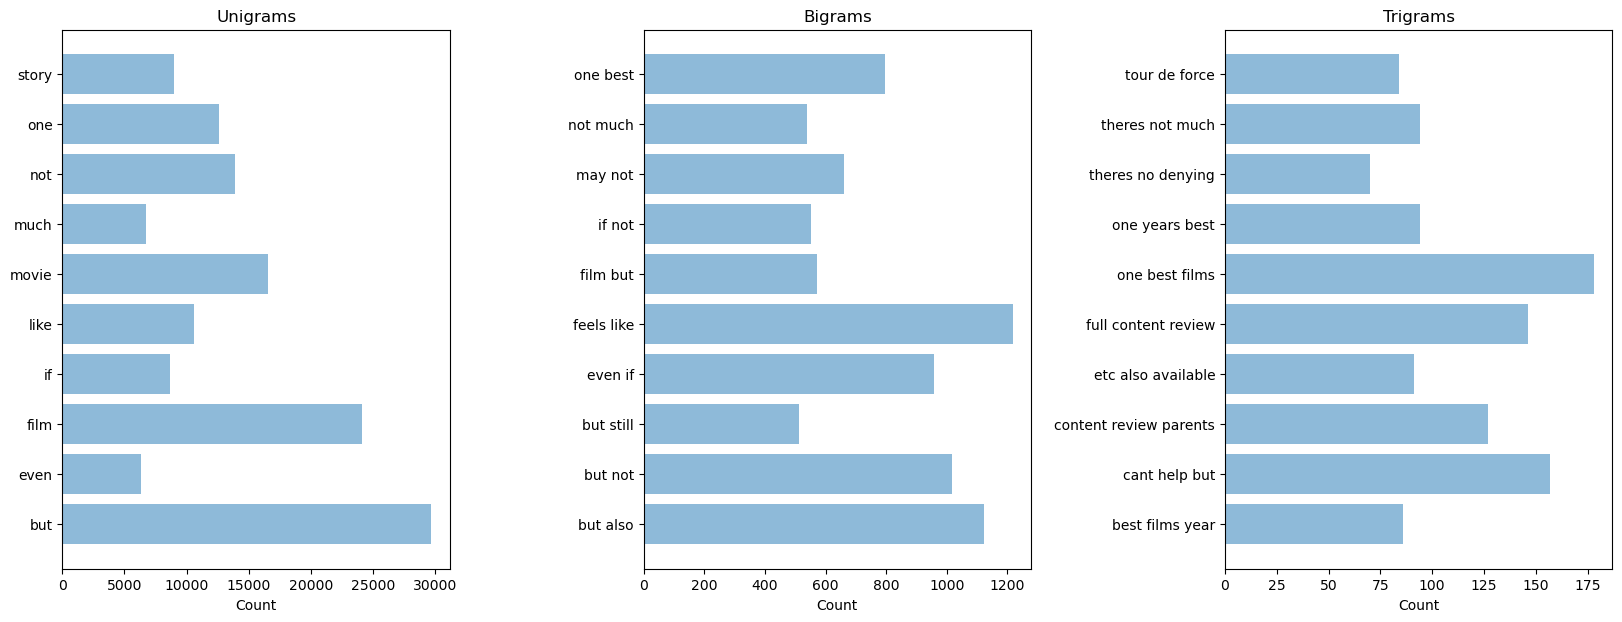

In [36]:
textTrends(df['cleanedText'])

In further analysis it was found that **genre,originalLanguage,word_count,mw_len,cw_count and runtimeMinutes** also dont contribute much and lead to overfit therefore removing them as well

In [37]:
df=df.drop(columns=['genre','originalLanguage','runtimeMinutes',
                    'word_count','cw_count','mw_len'])

# **Encoding and Splitting Data**

**Now its time to encode and split data**

1. For **reviewText** we have used CountVectorizer rather than TfidfVectorizer and it gave on an avg. **1.5%** better accuracy than Tfidf.We will initially select 5 Lakh features from are ngrams out of 28 Lakh.After this we use **chi square** and **MI** test along with **SelectKBest** to select 250000 top features.In the end manually slecting top 250000 features from our review text vecotrs gave best result. 

2. For Scaling we are using MinMaxScaler.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack,csr_matrix
import numpy as np



def preprocess_df(df,mf):
    global scale_score
    global scale_pol
    global encode
    global encode_movie
    global vectorizer3
    global vectorizer5
    global matrix5
            
    encode= OneHotEncoder(handle_unknown='ignore')
    encode_movie = OneHotEncoder(handle_unknown='ignore')
    scale_pol = MinMaxScaler()
    scale_score = MinMaxScaler()
    vectorizer3 = CountVectorizer(preprocessor=data_cleaning)
    vectorizer5 = CountVectorizer(preprocessor=data_cleaning,ngram_range=(1,3),max_features=mf)

    freq=np.array(df['isFrequentReviewer']).reshape( df.shape[0],1)
    
    score=scale_score.fit_transform(np.array(df['audienceScore']).reshape(-1,1)).astype(np.float16)
    
    polarity=scale_pol.fit_transform(np.array(df['polarity']).reshape(-1,1)).astype(np.float16)
    
    matrix3=vectorizer3.fit_transform(df['director']).astype(np.float16)
    
    matrix5=vectorizer5.fit_transform(df['reviewText']).astype(np.float16)
    
    names=encode.fit_transform(np.array(df['reviewerName']).reshape(-1,1)).astype(np.float16)
    
    movies=encode_movie.fit_transform(np.array(df['title']).reshape(-1,1)).astype(np.float16)
    
    stack=hstack((freq,score,polarity,matrix3,movies,names,matrix5)).astype(np.float16)
    
    y=df['sentiment'].astype(np.float16)
    
    return stack,y


In [39]:
stack,y=preprocess_df(df,250000)
X_train, X_test, y_train, y_test=train_test_split(stack,y,test_size=0.2, random_state=42)

# **Feature Selection**

We tried chi2,mutual_info_classif test for feature selection but ultimately manually selecting 250000 features from **reviewText** vectorizer and taking rest of all features gave best results 

In [40]:
#Code for feature selection based upon chi2 or mutual_info_classif
'''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif,chi2, mutual_info_classif

k = 250000 
features = SelectKBest(mutual_info_classif, k=k)
X_train = features.fit_transform(X_train, y_train)

selected_features_mask = features.get_support()
selected_feature_indices = np.where(selected_features_mask)[0]

print("Selected feature indices:")
selected_feature_indices

X_test = features.transform(X_test)

'''

'\nfrom sklearn.feature_selection import SelectKBest\nfrom sklearn.feature_selection import f_classif,chi2, mutual_info_classif\n\nk = 250000 \nfeatures = SelectKBest(mutual_info_classif, k=k)\nX_train = features.fit_transform(X_train, y_train)\n\nselected_features_mask = features.get_support()\nselected_feature_indices = np.where(selected_features_mask)[0]\n\nprint("Selected feature indices:")\nselected_feature_indices\n\nX_test = features.transform(X_test)\n\n'

# **Fitting Models**

We are using SVM with linear kernel,Logistic regression and Bernoulli Naive Bayes as our primary models.Other than them XGBoost classifier is also fitted.Hyperparameter tuning is shown for 3 primary models.

 We will store all models and their accuracy in a list named **models**

In [41]:
models=[]

 # 1. Logistic Regression

In [42]:
#LOGISTIC REGRESSION HP TUNING
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression

#Using liblinear solver as its much faster than lbfgs for our dataset
lr = LogisticRegression(penalty='l2',solver='liblinear',random_state=42)


param_distributions = {
    'C':[1,0.1,0.001,0.0001,100,1000],
    'max_iter':[1000, 2000,3000,4000],
    'tol':[0.1,0.001,0.0001,0.00001]
}


random_search = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_distributions,
    n_iter=100,  
    cv=5,       
    random_state=42,
    n_jobs=-1   
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
lr = random_search.best_estimator_

pred_lg = lr.predict(X_test)
acc=lr.score(X_test,y_test)
models.append(('Logistic',lr,acc))
    
print(classification_report(y_test,pred_lg))
print(best_params)

              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74     10837
         1.0       0.86      0.90      0.88     21715

    accuracy                           0.84     32552
   macro avg       0.82      0.80      0.81     32552
weighted avg       0.83      0.84      0.83     32552

{'tol': 0.001, 'max_iter': 1000, 'C': 1}


**PR Curve and Confusion Matrix for logistic model**

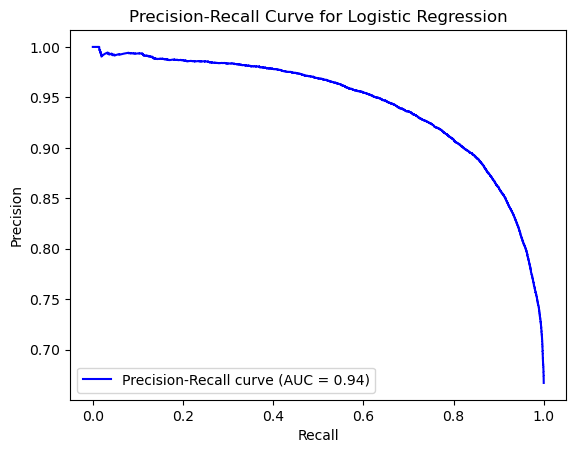

In [43]:
from sklearn.metrics import precision_recall_curve, auc
y_probs = lr.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Calculate area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', label='Precision-Recall curve (AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc='lower left')
plt.show()

<Figure size 640x480 with 0 Axes>

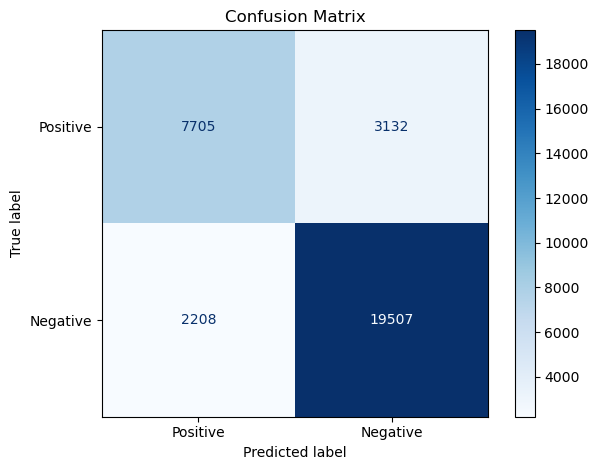

In [44]:
plt.figure()
cm = confusion_matrix(y_test, pred_lg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# 2. Bernoulli Naive Bayes  

In [45]:
from sklearn.naive_bayes import BernoulliNB


nb = BernoulliNB()


param_dist = {
    'alpha': np.logspace(-6, 0, 100), 
    'fit_prior': [True, False]
}

random_search = RandomizedSearchCV(nb, param_distributions=param_dist, n_iter=100, scoring='accuracy', cv=5, random_state=42)

random_search.fit(X_train, y_train)


best_params = random_search.best_params_
nb = random_search.best_estimator_


acc = nb.score(X_test, y_test)
models.append(('Naive Bayes',nb,acc))
pred_nb = nb.predict(X_test)
print(classification_report(y_test,pred_nb))
print(best_params)

              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73     10837
         1.0       0.87      0.85      0.86     21715

    accuracy                           0.82     32552
   macro avg       0.79      0.80      0.80     32552
weighted avg       0.82      0.82      0.82     32552

{'fit_prior': True, 'alpha': 0.572236765935022}


**PR Curve and confusion matrix for Bernoulli Naive Bayes**

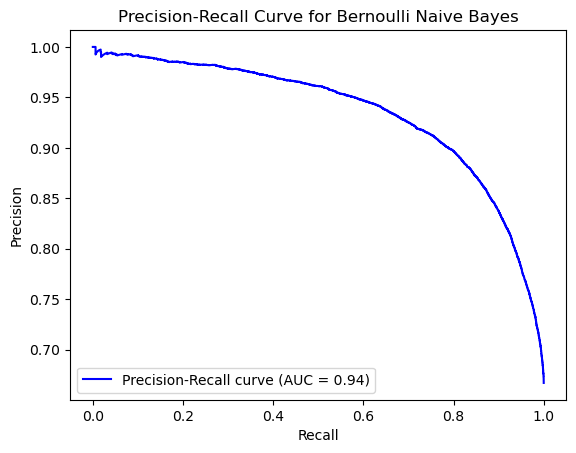

In [46]:
from sklearn.metrics import precision_recall_curve, auc
y_probs = nb.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Calculate area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', label='Precision-Recall curve (AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Bernoulli Naive Bayes')
plt.legend(loc='lower left')
plt.show()

<Figure size 640x480 with 0 Axes>

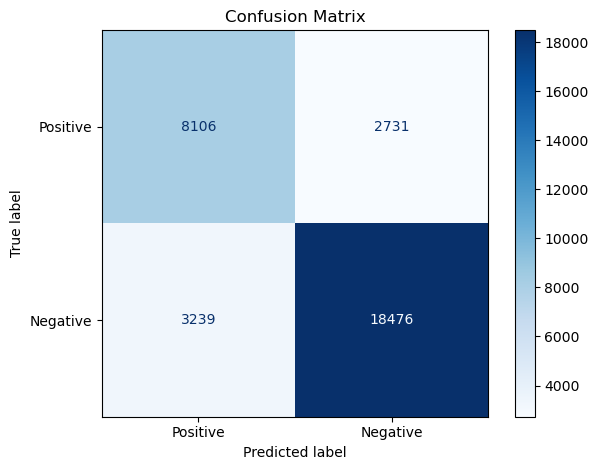

In [47]:
plt.figure()
cm = confusion_matrix(y_test, pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# 3. Linear SVM

We earlier fitted SVM(SVC) on datset with Hyperparameter tuning.It gave linear kernel as te one giving best results therefore we have fitted that now with LinearSVC which is a faste implementation of linear kernel SVM.

In [48]:
#LINEAR SVM HP TUNING
warnings.filterwarnings("ignore")

from sklearn.svm import LinearSVC


param_distributions = {
    'max_iter':[2000,3000,4000,6000],
    'loss': ['squared_hinge'],
    'C': [0.1,0.01,0.001,0.0001,1,10,100],
    'class_weight': [None, 'balanced']
}


lsvm = LinearSVC(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lsvm,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,       
    random_state=42,
    n_jobs=-1   
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
lsvm = random_search.best_estimator_

pred_lsvm = lsvm.predict(X_test)
acc=lsvm.score(X_test,y_test)
models.append(('Linear SVM',lsvm,acc))
print(classification_report(y_test,pred_lsvm))
print(best_params)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

         0.0       0.80      0.67      0.73     10837
         1.0       0.85      0.92      0.88     21715

    accuracy                           0.84     32552
   macro avg       0.83      0.79      0.81     32552
weighted avg       0.83      0.84      0.83     32552

{'max_iter': 2000, 'loss': 'squared_hinge', 'class_weight': None, 'C': 0.01}


**PR curve with auc and Confusion Matrix for linear SVM with taking predictions as probability functionality is not available**

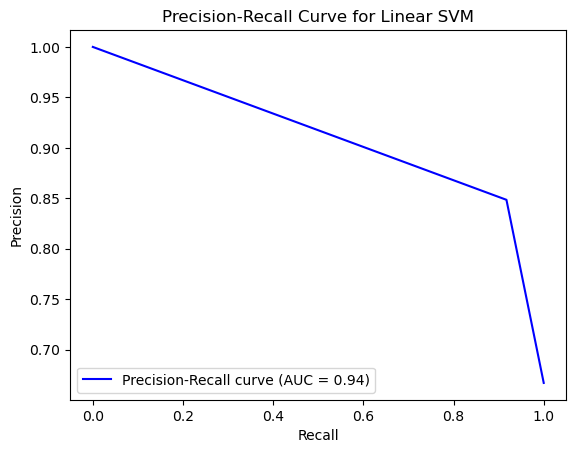

In [49]:
from sklearn.metrics import precision_recall_curve,confusion_matrix, ConfusionMatrixDisplay

precision, recall, _ = precision_recall_curve(y_test, pred_lsvm)

plt.figure()
plt.plot(recall, precision, color='blue', label='Precision-Recall curve (AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear SVM')
plt.legend(loc='lower left')
plt.show()


<Figure size 640x480 with 0 Axes>

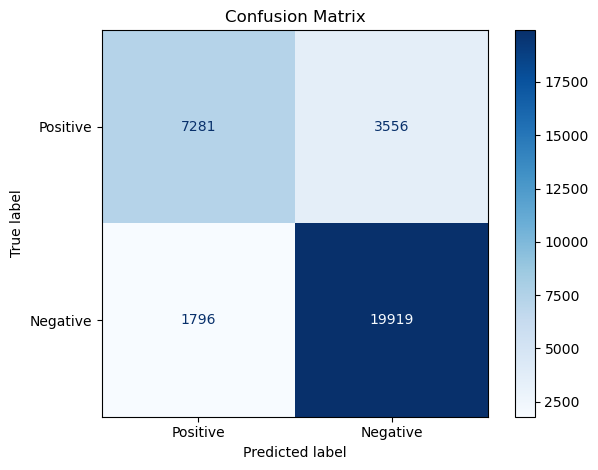

In [50]:
cm = confusion_matrix(y_test, pred_lsvm)
plt.figure()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# 4. XGBoost 

In [51]:
import xgboost as xgb

params = {
    'objective': 'binary:logistic',
    'n_estimators': 1000,
    'use_label_encoder': False,
    'tree_method': 'gpu_hist',
}


xg = xgb.XGBClassifier(**params)


xg.fit(X_train, y_train)


pred_xg = xg.predict(X_test)


acc = accuracy_score(y_test, pred_xg)
models.append(('XGB',xg,acc))
print(classification_report(y_test,pred_xg))

              precision    recall  f1-score   support

         0.0       0.77      0.65      0.70     10837
         1.0       0.84      0.90      0.87     21715

    accuracy                           0.82     32552
   macro avg       0.80      0.77      0.79     32552
weighted avg       0.81      0.82      0.81     32552



**Confusion Matrix for XGBoost**

<Figure size 640x480 with 0 Axes>

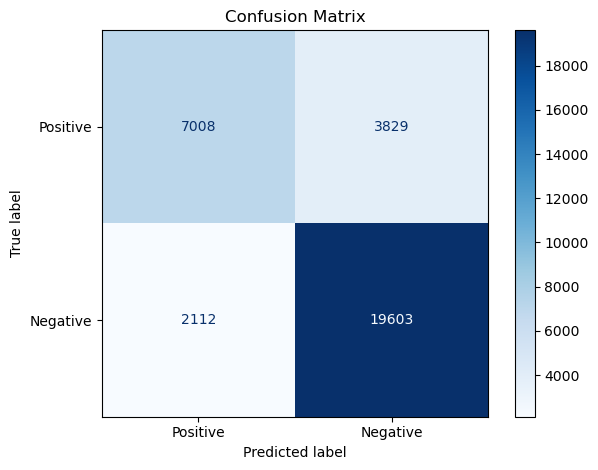

In [52]:
plt.figure()
cm = confusion_matrix(y_test, pred_xg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [53]:
model_table = pd.DataFrame(models, columns=['Model', 'Model Object','Accuracy'])


best_model_info = max(models, key=lambda x: x[2])

best_model_name, best_model, best_accuracy = best_model_info


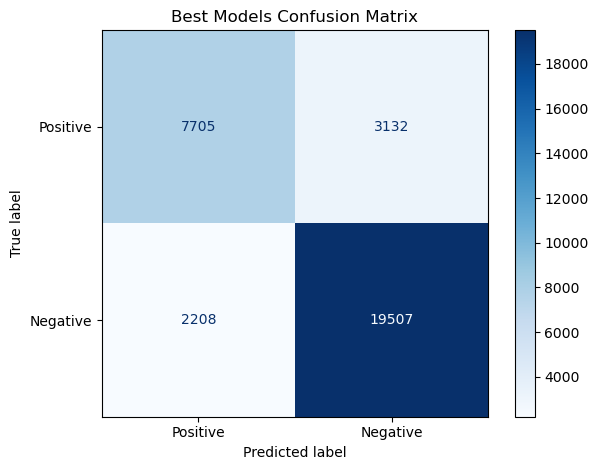

In [54]:
from sklearn.metrics import confusion_matrix

best_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Best Models Confusion Matrix')

plt.tight_layout()
plt.show()

In [55]:
best_model.fit(stack, y)

LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear',
                   tol=0.001)

In [56]:
model_table.head()

,Model,Model Object,Accuracy
0,Logistic,"LogisticRegression(C=1, max_iter=1000, random_...",0.835955
1,Naive Bayes,BernoulliNB(alpha=0.572236765935022),0.816601
2,Linear SVM,"LinearSVC(C=0.01, max_iter=2000, random_state=42)",0.835586
3,XGB,"XGBClassifier(base_score=None, booster=None, c...",0.817492


****Debugging and Identification of Drawbacks****

In [57]:
df['predictions']=best_model.predict(stack)
mis=df[df['predictions']!=df['sentiment']]
mis=mis[mis['sentiment']==0]

In [58]:
mis.head(10)

,movieid,title,audienceScore,releaseDateStreaming,director,reviewerName,isFrequentReviewer,reviewText,sentiment,cleanedText,polarity,predictions
24,adventure_captain_america_harry_potter,Adventure Captain America Harry Potter,70.0,[2017-11-07],MichelleRainey DessieGilchrist,Kristin Davis DDS,0,"Walls's story, so fresh and vivid in her memoi...",0,wallss story fresh vivid memoir perfectly watc...,0.33,1.0
93,adventure_e.t._marty_mcfly,Adventure E.T. Marty McFly,76.0,[2011-01-25],PhillipOdom,Justin Becker,1,It shorts its audience on the rich and vibrant...,0,shorts audience rich vibrant experience contin...,0.44,1.0
129,adventure_edward_scissorhands_travis_bickle_neo,Adventure Edward Scissorhands Travis Bickle Neo,70.0,[2019-08-27],GeorgeWarfield,Jennifer Lane,0,It has no tension.,0,no tension,0.13,1.0
192,adventure_epic,Adventure Epic,77.0,[2004-06-29],LyleNess,Jean Choi,0,Beauty and skill bereft of passion or personal...,0,beauty skill bereft passion personality,0.51,1.0
194,adventure_epic,Adventure Epic,77.0,[2004-06-29],LyleNess,Phyllis Ballard,0,While the film is handsome to look at and has ...,0,film handsome look fair share realism also get...,0.43,1.0
220,adventure_fantasy_miracle,Adventure Fantasy Miracle,93.0,[2006-04-25],LewisPhelps,Sabrina Norton,0,,0,,0.35,1.0
285,adventure_james_t._kirk_tyler_durden,Adventure James T. Kirk Tyler Durden,48.0,[2006-08-22],BillyDiaz,Ralph Dean,0,,0,,0.35,1.0
333,adventure_marvelous_jon_snow_dorothy_gale,Adventure Marvelous Jon Snow Dorothy Gale,91.0,[2002-10-22],JuliaTinoco,Omar Sharp,0,,0,,0.35,1.0
435,adventure_tony_montana_ellen_ripley,Adventure Tony Montana Ellen Ripley,54.0,"[2014-10-13, 2005-05-31]",EzequielShone GeorgeCaylor,Calvin Moore,0,,0,,0.35,1.0
490,adventure_wondrous_dream_mystic,Adventure Wondrous Dream Mystic,61.0,"[2005-09-06, 1998-11-17, 2017-01-28]",GeraldMartin BradyHodge DavidPhillies DannySmi...,Savannah Zhang,0,,0,,0.35,1.0


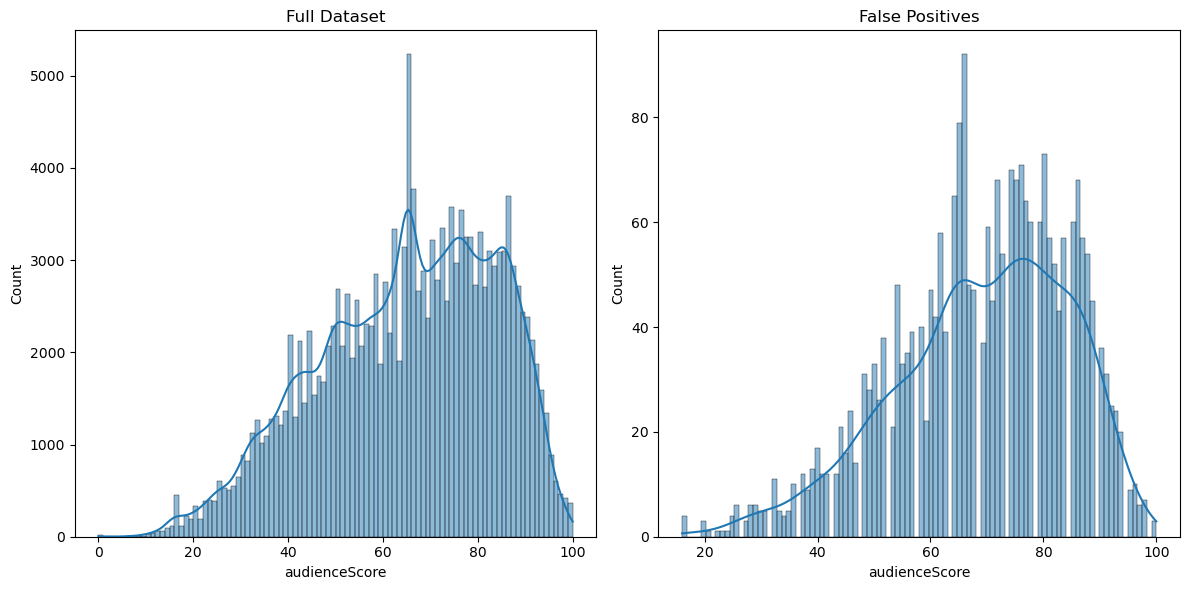

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


sns.histplot(data=df['audienceScore'],bins=100, kde=True, ax=axes[0])
axes[0].set_title('Full Dataset')


sns.histplot(data=mis['audienceScore'],bins=100, kde=True, ax=axes[1])
axes[1].set_title('False Positives')


plt.tight_layout()


plt.show()


Our false positive rate is high.Which is also signified by the prevalence of relatively **positive words** in misclassified negative reviews.Also mean **audienceScore** is higher for these data points

# **Preparing Test data for Submisssion**

**Function for merging test data with movies**

In [60]:
score_fill=round(df['audienceScore'].mean(),0)
def merge_movies_test(meta,main):

  main = main.merge(meta,on='movieid', sort=False).sort_values(by='index')


  main['isTopCritic']=main['isTopCritic'].replace({True: 1, False: 0})
  main['audienceScore']=main['audienceScore'].fillna(score_fill)
    
  main['reviewText']=main['reviewText'].fillna('')



  return main

test['index'] = test.index
test=merge_movies_test(movies,test)

****Calculating polarity for test****

In [61]:
test['polarity']=np.nan

for index,value in test.iterrows():
    pos=0
    neg=0
    text=data_cleaning(value['reviewText']).split()
    for j in text:
        if j not in words:
            continue
        neg+=words[j][0]
        pos+=words[j][1]
    
    polarity_score = round((pos - neg) / max(1, pos + neg),2)
    if polarity_score==0:
        continue
    else:
        test.loc[index,'polarity']=polarity_score
    
        

test['polarity']=test['polarity'].fillna(round(df['polarity'].mean(),2)) 


**Encoding Test Data**

In [62]:

freq_test = np.array(test['isTopCritic'].astype(np.int16) ).reshape(55315,1).astype(np.float16)
score_test = scale_score.transform(test['audienceScore'].values.reshape(-1, 1)).astype(np.float16)
polarity_test=scale_pol.transform(test['polarity'].values.reshape(-1,1)).astype(np.float16) 
names_test=encode.transform(np.array(test['reviewerName']).reshape(-1,1)).astype(np.float16)
movies_test=encode_movie.transform(np.array(test['title']).reshape(-1,1)).astype(np.float16)
test_matrix3 = vectorizer3.transform(test['director'])
test_matrix5 = vectorizer5.transform(test['reviewText'])

stack_test=hstack((freq_test,score_test,polarity_test,test_matrix3,movies_test,names_test,test_matrix5))

**Predicting and submitting**

In [63]:
prediction=best_model.predict(stack_test)
prediction=np.where(prediction == 1, 'POSITIVE', 'NEGATIVE')

submission = pd.DataFrame(columns=['id','sentiment'])

In [64]:
submission['id'] = [i for i in range(55315)]
submission['sentiment'] = prediction
submission

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
...,...,...
55310,55310,POSITIVE
55311,55311,POSITIVE
55312,55312,NEGATIVE
55313,55313,POSITIVE


In [65]:
submission.to_csv('submission.csv',index =False)